# Cleaning and Arranging the data

In [1]:
import argparse
from collections import defaultdict, Counter
import cv2
from fuzzywuzzy import fuzz
from itertools import combinations # not mandatory
import imutils
from imutils import build_montages, paths
import os
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
import string

/Users/aburshtein/anaconda3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Define useful functions for cleaning the data

In [2]:
def remove_parentheses(string):
    pattern = r'\([^()]*\)'  # Matches "(...)" pattern
    while re.search(pattern, string):
        string = re.sub(pattern, '', string)
    return string.strip()

def format_ingredients(string):
    string = string.replace('.', '')  # Remove periods
    string = re.sub(r'\s*,\s*', ',', string)  # Remove spaces after commas
    ingredients_list = string.split(',')  # Split by comma
    formatted_ingredients = [ingredient.strip() for ingredient in ingredients_list]  # Remove leading/trailing spaces for each ingredient
    return ', '.join(formatted_ingredients)  # Join formatted ingredients with commas

def clean_text_values(df):
    text_columns = df.select_dtypes(exclude=[np.number]).columns
    for column in text_columns:
        if column == 'category':
            continue
        df[column].fillna('NA', inplace=True)
        df[column] = df[column].map(str.lower)
        if column == 'ingredients':
            df[column] = df[column].apply(remove_parentheses)
            df[column] = df[column].apply(format_ingredients)
        if column == 'household_serving_fulltext':
            df[column] = df[column].map(lambda x: re.sub('[^a-z]+', '', x))
    return df

In [3]:
food_train = pd.read_csv('data/food_train.csv')
food_test = pd.read_csv('data/food_test.csv')
food_nutrients = pd.read_csv('data/food_nutrients.csv')
nutrients_names = pd.read_csv('data/nutrients.csv')

In [4]:
clean_text_values(food_train).head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category
0,1,brix chocolate,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits
4,5,"ferrero u.s.a., incorporated","ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate


In [5]:
nutrients = pd.merge(food_nutrients, nutrients_names, how='left',on='nutrient_id')
nutrients.head()

,idx,nutrient_id,amount,name,unit_name
0,1,1087,143.00,"Calcium, Ca",MG
1,1,1089,5.14,"Iron, Fe",MG
2,1,1104,0.00,"Vitamin A, IU",IU
3,1,1162,0.00,"Vitamin C, total ascorbic acid",MG
4,1,1003,7.14,Protein,G


In [6]:
pivoted_nutrients = pd.pivot_table(nutrients, values='amount', index='idx', columns='name')
data = pd.merge(food_train, pivoted_nutrients, how='left', on='idx')
data.head() 

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,"Vitamin A, IU",Vitamin B-12,Vitamin B-6,"Vitamin C, total ascorbic acid","Vitamin D (D2 + D3), International Units",Vitamin E,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),Xylitol,"Zinc, Zn"
0,1,brix chocolate,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,NaN,NaN,...,526.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,NaN,NaN,...,667.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"ferrero u.s.a., incorporated","ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## Enums

In [7]:
CANDY = 'candy'
COOKIES = 'cookies_biscuits'
CAKES = 'cakes_cupcakes_snack_cakes'
CHIPS_PRETZELS = 'chips_pretzels_snacks'
CHOCOLATE = 'chocolate'
POPCORN_PEANUTS = 'popcorn_peanuts_seeds_related_snacks'

## Select by Category

In [8]:
def data_by_category(df, category):
    return df[df['category'] == category]

In [9]:
candy_data = data_by_category(data, CANDY)
cookies_data = data_by_category(data, COOKIES)
cakes_data = data_by_category(data, CAKES)
chips_pretzels_data = data_by_category(data, CHIPS_PRETZELS)
chocolate_data = data_by_category(data, CHOCOLATE)
popcorn_peanuts_data = data_by_category(data, POPCORN_PEANUTS)

candy_data.head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,"Vitamin A, IU",Vitamin B-12,Vitamin B-6,"Vitamin C, total ascorbic acid","Vitamin D (D2 + D3), International Units",Vitamin E,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),Xylitol,"Zinc, Zn"
9,10,"schnuck markets, inc.",laffy taffy,"corn syrup, sugar, palm oil and less than 2% o...",39.0,g,piece,candy,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
20,25,golden packaging company,"american golden, ginger crystallized golden pack","ginger, sugar, citric acid",28.0,g,onz,candy,NaN,NaN,...,179.0,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN
48,55,solo,marshmallow creme,"corn syrup, sugar, water, egg whites, artifici...",12.0,g,tbsp,candy,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,65,richardson brands company,"colombina, tiger pops","corn syrup, sugar, citric acid, artificial fla...",10.0,g,pop,candy,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
79,87,ferrara candy company,"jujyfruits, chewy fruity candy, fruity","corn syrup, sugar, modified and unmodified cor...",59.0,g,package,candy,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def better_name(df, col_name):
    df[col_name] = df[col_name].map(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))
    return(df)

# Select only TOP 15 Brands for each category

In [11]:
def top_15_brands_by_category(df, category):
    df_by_category = df[df['category'] == category]
    return df_by_category.groupby('brand').size().sort_values(ascending=False).head(15)

def select_only_the_top_brand(df):
    better_name(df, 'brand')
    top_brand_dict={'candy': top_15_brands_by_category(df, CANDY).index.tolist(),
                   'cookies': top_15_brands_by_category(df, COOKIES).index.tolist(),
                   'cakes': top_15_brands_by_category(df, CANDY).index.tolist(),
                   'chips_pretzels': top_15_brands_by_category(df, CHIPS_PRETZELS).index.tolist(),
                   'chocolate': top_15_brands_by_category(df, CHOCOLATE).index.tolist(),
                   'popcorn_peanuts': top_15_brands_by_category(df, POPCORN_PEANUTS).index.tolist()}
    df['brand'].fillna('unbranded',inplace=True)
    brands_list = []
    for key, value in top_brand_dict.items():
        if 'not a branded item' in value:
            value.remove('not a branded item')
        brands_list.extend(value)  
    df['brand'] = df['brand'].map(lambda x: x if x in brands_list else 'unbranded')
    return df

In [12]:
df = select_only_the_top_brand(data)
df.head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,"Vitamin A, IU",Vitamin B-12,Vitamin B-6,"Vitamin C, total ascorbic acid","Vitamin D (D2 + D3), International Units",Vitamin E,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),Xylitol,"Zinc, Zn"
0,1,unbranded,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,NaN,NaN,...,526.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,NaN,NaN,...,667.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,unbranded,"ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# handling household_serving_fulltext column

In [15]:
def extract_household_serving_fulltext(data):
    words_of_cake = ['cake', 'brownie', 'donut', 'muffin', 'tart', 'torte', 'doughnut','slice', 'pastry', 'bun', 'loaf']
    words_of_candys = ['candies', 'candy','gummies', 'gummy', 'marshmallow', 'pop', 'twist', 'stick','bear']
    words_of_chips_pretzels = ['chip', 'chips', 'fries', 'crisp', 'pretzel']
    words_of_chocolate = ['truffle', 'praline', 'pralines', 'square', 'block', 'ball', 'balls', 'tablet']
    words_of_cookie = ['cookie', 'cookies', 'wafer', 'cracker', 'biscuit', 'macaroon', 'waffle']
    words_of_popcorn_peanuts = ['kernel', 'popcorn', 'almond', 'shell', 'pecan']
  
    mat = np.full((len(data), 6), False, dtype=bool)
  
    for i in range(0,len(data)):
        mat[i,0] = data[i] in words_of_cake
        mat[i,1] = data[i] in words_of_candys
        mat[i,2] = data[i] in words_of_chips_pretzels
        mat[i,3] = data[i] in words_of_chocolate
        mat[i,4] = data[i] in words_of_cookie
        mat[i,5] = data[i] in words_of_popcorn_peanuts
    
    headers = ["HSF_cake_indication", "HSF_candy_indication", "HSF_chips_pretzels_indication", "HSF_chocolate_indication", 
               "HSF_cookie_indication", "HSF_popcorn_peanuts_indication"]
    df = pd.DataFrame(mat)
    df.columns = headers
    return(df)

indicative_data = extract_household_serving_fulltext(df["household_serving_fulltext"])
for col in indicative_data.columns:
    df[col] = indicative_data[col]
    
df.head(15)

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),Xylitol,"Zinc, Zn",HSF_cake_indication,HSF_candy_indication,HSF_chips_pretzels_indication,HSF_chocolate_indication,HSF_cookie_indication,HSF_popcorn_peanuts_indication
0,1,unbranded,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,5,unbranded,"ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
5,6,the kroger co,"kroger, chipmates, cookies, chocolate chips","enriched flour, chocolate chips, sugar, partia...",36.0,g,cookies,cookies_biscuits,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
6,7,the kroger co,chocolate chip cookies,"enriched flour, milk chocolate flavored candy ...",28.0,g,cookies,cookies_biscuits,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
7,8,unbranded,"spaans, sugar free spiced windmill cookies","enriched wheat flour, shortening, maltodextrin...",28.4,g,cookies,cookies_biscuits,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,True,False
8,9,unbranded,cinnamon swirl sliced creme cake,"maltitol* and sorbitol* syrup, eggs, bleached ...",64.0,g,slices,cakes_cupcakes_snack_cakes,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
9,10,unbranded,laffy taffy,"corn syrup, sugar, palm oil and less than 2% o...",39.0,g,piece,candy,NaN,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False


# handling description column

In [17]:
def extract_description(data):
    words_of_cake = ['cake', 'cakes', 'cupcakes', 'cheezecake', 'coffeecake', 'brownie', 'brownies', 'slice', 'sliced', 
                     'torte', 'pie', 'pies', 'donut', 'donuts', 'bakery']
    words_of_candys = ['candy', 'candies', 'gummy', 'gummi', 'gummies', 'twist', 'stick', 'marshmallow', 'marshmallows',
                       'jelly', 'snacks', "sweet's"]
    words_of_chips_pretzels = ['chips', 'chip', 'tortilla', 'crisps', 'crisp', 'potato', 'pretzel', 'pretzels', 'fries', 'corn']
    words_of_chocolate = ['cocoa', 'praline', 'toffee', 'belgian', 'dark', 'truffle', 'chocolates']
    words_of_cookie = ['cookie', 'cookies', 'crackers', 'frosted', 'wafer', 'cracker', 'biscuit', 'macaroon', 'waffle']
    words_of_popcorn_peanuts = ['kernel', 'popcorn', 'almond', 'shell', 'pecan']
  
    mat = np.full((len(data), 6), False, dtype=bool)
  
    for i in range(0,len(data)):
        mat[i,0] = any(word in str(data[i]) for word in words_of_cake)
        mat[i,1] = any(word in str(data[i]) for word in words_of_candys)
        mat[i,2] = any(word in str(data[i]) for word in words_of_chips_pretzels)
        mat[i,3] = any(word in str(data[i]) for word in words_of_chocolate)
        mat[i,4] = any(word in str(data[i]) for word in words_of_cookie)
        mat[i,5] = any(word in str(data[i]) for word in words_of_popcorn_peanuts)
    
    headers = ["des_cake_indication", "des_candy_indication", "des_chips_pretzels_indication", "des_chocolate_indication", 
               "des_cookie_indication", "des_popcorn_peanuts_indication"]
    df = pd.DataFrame(mat)
    df.columns = headers
    return(df)

indicative_data = extract_description(df["description"])
for col in indicative_data.columns:
    df[col] = indicative_data[col]
    
df.head(15)

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,HSF_chips_pretzels_indication,HSF_chocolate_indication,HSF_cookie_indication,HSF_popcorn_peanuts_indication,des_cake_indication,des_candy_indication,des_chips_pretzels_indication,des_chocolate_indication,des_cookie_indication,des_popcorn_peanuts_indication
0,1,unbranded,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,NaN,NaN,...,False,False,True,False,False,False,False,False,True,False
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,NaN,NaN,...,False,False,True,False,False,False,False,False,True,False
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
4,5,unbranded,"ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
5,6,the kroger co,"kroger, chipmates, cookies, chocolate chips","enriched flour, chocolate chips, sugar, partia...",36.0,g,cookies,cookies_biscuits,NaN,NaN,...,False,False,True,False,False,False,True,False,True,False
6,7,the kroger co,chocolate chip cookies,"enriched flour, milk chocolate flavored candy ...",28.0,g,cookies,cookies_biscuits,NaN,NaN,...,False,False,True,False,False,False,True,False,True,False
7,8,unbranded,"spaans, sugar free spiced windmill cookies","enriched wheat flour, shortening, maltodextrin...",28.4,g,cookies,cookies_biscuits,NaN,NaN,...,False,False,True,False,False,False,False,False,True,False
8,9,unbranded,cinnamon swirl sliced creme cake,"maltitol* and sorbitol* syrup, eggs, bleached ...",64.0,g,slices,cakes_cupcakes_snack_cakes,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False
9,10,unbranded,laffy taffy,"corn syrup, sugar, palm oil and less than 2% o...",39.0,g,piece,candy,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


# handling serving_size column - May be not necessary

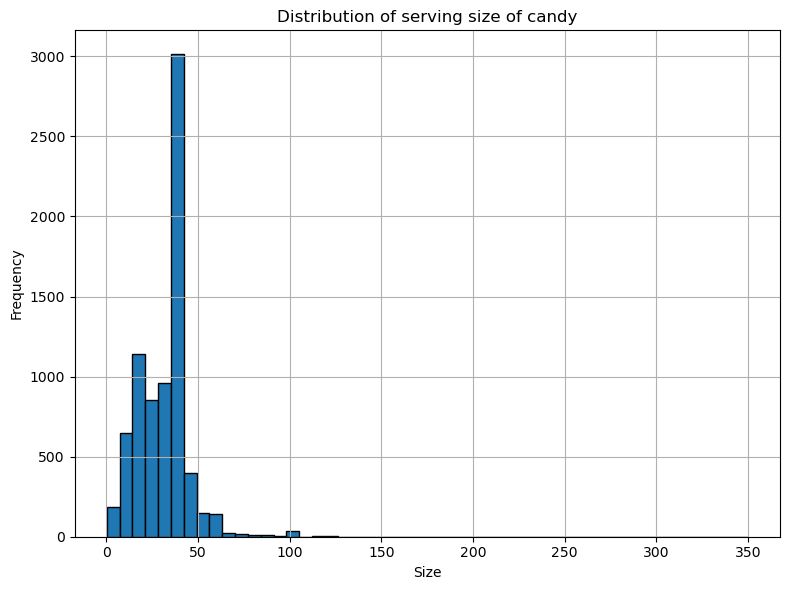

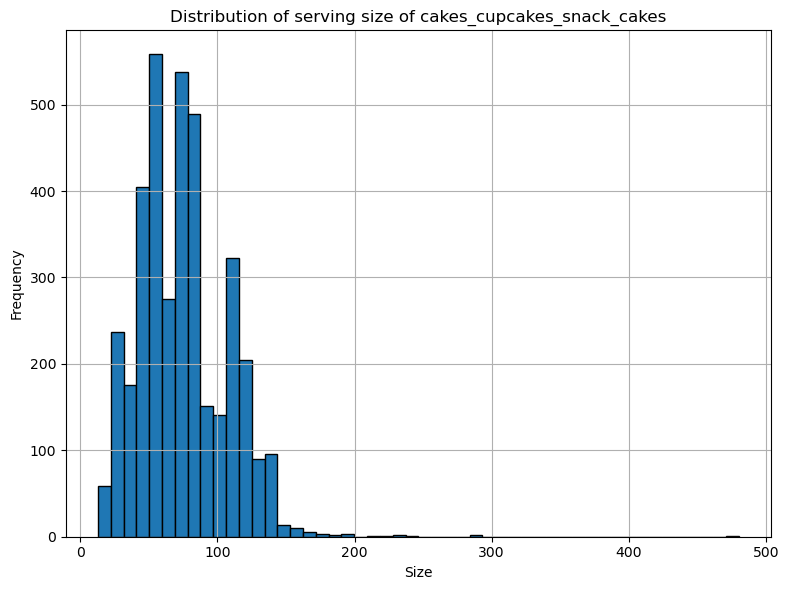

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,HSF_cookie_indication,HSF_popcorn_peanuts_indication,des_cake_indication,des_candy_indication,des_chips_indication,des_chocolate_indication,des_cookie_indication,des_popcorn_peanuts_indication,candy_size,cakes_cupcakes_snack_cakes_size
0,1,unbranded,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,NaN,NaN,...,True,False,False,False,False,False,True,False,True,False
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,NaN,NaN,...,True,False,False,False,False,False,True,False,False,False
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil, cocoa powder processed w...",40.0,g,pieces,cookies_biscuits,NaN,NaN,...,False,False,False,False,False,False,True,False,True,False
4,5,unbranded,"ferrero collection, fine assorted confections","semisweet chocolate, sugar, vegetable oils, co...",40.0,g,pieces,chocolate,NaN,NaN,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31746,35272,safeway inc,"honey wheat pretzel braids, honey wheat","enriched wheat flour, whole wheat flour, sugar...",28.0,g,onz,chips_pretzels_snacks,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False
31747,35273,safeway inc,"candy, gummi bears","corn syrup, sugar, gelatin, modified food star...",31.0,g,pieces,candy,NaN,NaN,...,False,False,False,True,False,False,False,False,False,False
31748,35274,unbranded,"potato chips, barbecue","potatoes, vegetable oil, bbq seasoning",28.0,g,onz,chips_pretzels_snacks,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False
31749,35275,unbranded,"potato chips, sour cream & onion","potatoes, vegetable oil, seasoning",28.0,g,onz,chips_pretzels_snacks,NaN,NaN,...,False,False,False,False,True,False,False,False,False,False


In [25]:
def size_range_of_snacks_from_same_categiry(df_by_category, category):
    # Determine the range for the histogram bins
    bin_range = np.arange(df_by_category['serving_size'].min(), df_by_category['serving_size'].max() + 6, 10)
    # Create the histogram
    plt.figure(figsize=(8, 6))
    hist, bin_edges, _ = plt.hist(df_by_category['serving_size'], bins=50, edgecolor='black')
    plt.xlabel('Size')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of serving size of {category}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    # Find the index of the bin with the highest frequency (largest column)
    index_largest_column = np.argmax(hist)

    # Get the range of numbers in the largest column
    lower_range = bin_edges[index_largest_column]
    upper_range = bin_edges[index_largest_column + 1]
    return [int(lower_range), int(upper_range)]


def add_col_category_size(df, category):
    df_by_category = df[df['category'] == category]
    category_range = size_range_of_snacks_from_same_categiry(df_by_category, category)
    df[f'{category}_size'] = df['serving_size'].copy()
    df[f'{category}_size'] = df[f'{category}_size'].map(lambda x: True if x in range(category_range[0], category_range[1]) else False)
    return df

add_col_category_size(df, CANDY)
add_col_category_size(df, CAKES)

# handling ingredients column

## CV - HW6 - Need to Change

In [ ]:
def get_ohe(df):
    temp_df = pd.DataFrame(data=ohe.transform(df[['brand',..]]), columns=ohe.get_feature_names_out())
    df.drop(columns=[...], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df

In [ ]:
# x_range = [10, 25, 50, 75, 100, 125, 150, 175, 200]
# performance_metrics = {}
# for p1 in x_range:
#     for p2 in x_range:
#         shoes_train = pd.read_csv('data/shoes_train.csv')
#         shoes_train['price'] = shoes_train['price'].apply(np.log)
#         X = shoes_train.loc[:,shoes_train.columns != 'price']
#         y = shoes_train['price']

#         # Split your dataset into training and validation sets
#         X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#         # Define the range of values for the parameter x
#         x_range = [10, 25, 50, 75, 100, 125, 150]

#         # Initialize a dictionary to store the performance metrics for each x value
#         # performance_metrics = {}

#         # Iterate over each x value and calculate the average performance metric
#         # for x in x_range:
#         # Apply the brand cleaning function with the current x value
#         X_train_cleaned = clear_data(X_train, p1, p2)
#         gb = HistGradientBoostingRegressor(random_state=42)
#         ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#         ohe.fit(X_train_cleaned[['brand','style','heel_height','material','occasion','country_region_of_manufacture',
#                                                       'color','vintage','location','condition','category']])

#         X_train_cleaned = get_ohe(X_train_cleaned)

#         mse = make_scorer(mean_squared_error)
#         # Perform cross-validation and calculate the performance metric (e.g., accuracy)
#         scores = cross_val_score(gb, X_train_cleaned, y_train, cv=5, scoring=mse, error_score='raise')
#         name = f"{p1}_{p2}"
#         print(f"{name}\n{scores}")
#         avg_score = np.sqrt(np.mean(scores))

#         name = f"{p1}_{p2}"
#         # Store the average performance metric for the current x value
#         performance_metrics[name] = avg_score

# # # Find the best value of x based on the highest average performance metric
# # best_x = max(performance_metrics, key=performance_metrics.get)

# # # Apply the brand cleaning function with the best x value to the entire training set
# # X_train_cleaned = brand_cleaning_function(X_train, best_x)

# # # Train the model using the best x value on the entire training set
# # classifier.fit(X_train_cleaned, y_train)

# # # Apply the brand cleaning function with the best x value to the validation set
# # X_val_cleaned = brand_cleaning_function(X_val, best_x)

# # # Evaluate the performance of the model on the validation set
# # y_val_pred = classifier.predict(X_val_cleaned)
# # val_accuracy = accuracy_score(y_val, y_val_pred)

# # # Print the best x value and the validation accuracy
# # print("Best x value:", best_x)
# # print("Validation accuracy:", val_accuracy)


In [ ]:
performance_metrics
best_p = min(performance_metrics, key=performance_metrics.get)
p = best_p.split('_')
p1 = int(p[0])
p2 = int(p[1])

# Model_1

# Model_2

# Model_3